In [1]:
import numpy as np
import matplotlib.pyplot as plt

from circuit_knitting.cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)
from circuit_knitting.cutting import cut_wires, partition_problem

from resource_analysis import *
from optimization_utils import *

from azure.quantum import Workspace
from azure.quantum.target.microsoft import MicrosoftEstimator, ErrorBudgetPartition

workspace = Workspace (
   resource_id = "/subscriptions/e0d51919-2dda-4b7e-a8e7-77cc18580acb/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/QECBenchmarking",
   location = "uksouth"
)

estimator = MicrosoftEstimator(workspace)

In [2]:
circuit = build_1D_hamiltonian(num_spins=50, t=1, num_timesteps=10, h=1)
# circuit.draw('mpl', scale=0.5)

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIII

In [3]:
# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)

# Specify the size of the QPUs available
device_constraints = DeviceConstraints(qubits_per_subcircuit=25)

cut_circuit, metadata = find_cuts(circuit, optimization_settings, device_constraints)
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling '
    f'overhead of {metadata["sampling_overhead"]}.'
)
# for cut in metadata["cuts"]:
#     print(f"{cut[0]} at circuit instruction index {cut[1]}")
# cut_circuit.draw("mpl", scale=0.8, fold=-1)

Found solution using 40 cuts with a sampling overhead of 1.4780882941434593e+38.


In [4]:
qc_w_ancilla = cut_wires(cut_circuit)
partitioned_problem = partition_problem(circuit=qc_w_ancilla)
subcircuit= partitioned_problem.subcircuits
subcircuits = [cuts_filter(s) for s in subcircuit.values()]
# subcircuits[0].draw("mpl", style="iqp", scale=0.5)

In [5]:
params = estimator.make_params(num_items=1)
params.error_budget = 0.01
params.constraints.max_t_factories = 1
job = estimator.submit(circuit, input_params=params)
r = job.get_results()
Q = r['physicalCounts']['physicalQubits']
T = r['physicalCounts']['runtime']*1e-3
print('\n', 'total physical qubits required: ', Q, '\n', 'total runtime', T)
# total physical qubits required:  8276 
# total runtime 3498.0

.......
 total physical qubits required:  83458 
 total runtime 1616992.4000000001


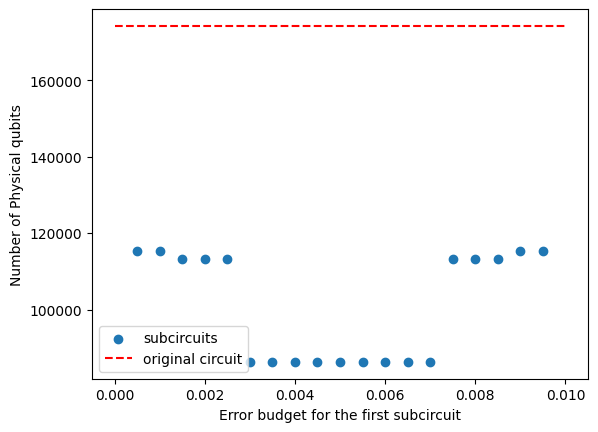

In [6]:
Q_approx = PhysicalParameters.make_beverland_et_al(circuit, error_budget=[0.01/3]*3).Q
q = []
sub_error_budget = [(0.01/20*e, 0.01-0.01/20*e) for e in range(1,20)]
for (e1, e2) in sub_error_budget:
    Q1 = PhysicalParameters.make_beverland_et_al(subcircuit[0], error_budget = [e1/3]*3).Q
    Q2 = PhysicalParameters.make_beverland_et_al(subcircuit[1], error_budget = [e2/3]*3).Q 
    q.append(max(Q1, Q2))

plt.scatter([e1 for (e1,e2) in sub_error_budget], q, label='subcircuits')
plt.plot([0, 0.01], [Q_approx, Q_approx], 'r--', label='original circuit')
plt.legend()
plt.xlabel('Error budget for the first subcircuit')
plt.ylabel('Number of Physical qubits')
plt.show()


86298.0 [3, 4, 5, 5, 5, 6, 6, 6, 10]


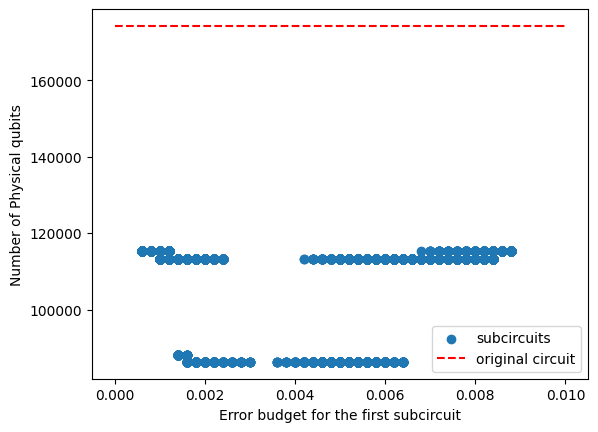

In [7]:
Q_approx = PhysicalParameters.make_beverland_et_al(circuit, error_budget=[0.01/3]*3).Q
q = []
sub_error1 = []
# sol = {}
sol_q = Q_approx
sol_e = None
partition = error_budget_partition(0.01, len(subcircuits)*3)
sub_error_budget = partition + [l[::-1] for l in partition]
for e in sub_error_budget:
    Q1 = PhysicalParameters.make_beverland_et_al(subcircuit[0], error_budget = [i/5000 for i in e[:3]]).Q
    Q2 = PhysicalParameters.make_beverland_et_al(subcircuit[1], error_budget = [i/5000 for i in e[3:]]).Q 
    m = max(Q1, Q2)
    q.append(m)
    sub_error1.append(sum(e[:3])/5000)
    if sol_q > m:
        sol_q = m
        sol_e = e
        
print(sol_q, sol_e)
plt.scatter(sub_error1, q, label='subcircuits')
plt.plot([0, 0.01], [Q_approx, Q_approx], 'r--', label='original circuit')
plt.legend()
# plt.ylim([min(q)-1000, Q_approx+1000])
plt.xlabel('Error budget for the first subcircuit')
plt.ylabel('Number of Physical qubits')
plt.show()


In [8]:
params1 = estimator.make_params(num_items=1)
params2 = estimator.make_params(num_items=1)
params1.items[0].constraints.max_t_factories = 1
params2.items[0].constraints.max_t_factories = 1
# params1.items[1].constraints.max_t_factories = 2
# params2.items[1].constraints.max_t_factories = 2

params1.error_budget = ErrorBudgetPartition(sol_e[0]/5000, sol_e[1]/5000, sol_e[2]/5000) 
params2.error_budget = ErrorBudgetPartition(sol_e[3]/5000, sol_e[4]/5000, sol_e[5]/5000) 

job1 = estimator.submit(subcircuit[0], input_params=params1)
r1 = job1.get_results()
job2 = estimator.submit(subcircuit[1], input_params=params2)
r2 = job2.get_results()

print('\n', 'subcircuit-1 : physical qubits--', r1['physicalCounts']['physicalQubits'], 'runtime (in microsec)--', r1['physicalCounts']['runtime']*1e-3)
print('\n', 'subcircuit-2 : physical qubits--', r2['physicalCounts']['physicalQubits'], 'runtime (in microsec)--', r2['physicalCounts']['runtime']*1e-3)

...........
 subcircuit-1 : physical qubits-- 49934 runtime (in microsec)-- 770100.0

 subcircuit-2 : physical qubits-- 49934 runtime (in microsec)-- 791737.6


In [9]:
classical_runtime = metadata["sampling_overhead"]/1e14
quantum_runtime = r1['physicalCounts']['runtime']*1e-3 + r2['physicalCounts']['runtime']*1e-3
print(classical_runtime, quantum_runtime)

1.4780882941434593e+24 1561837.6
